# Yiming to do

- Get on Slack and text me (check in with An Vo how to do this)
- Create a Github repo in which we will further develop this tutorial
- Familiarize yourself with looking up HSSM functions and tutorials here: https://lnccbrown.github.io/HSSM/api/hssm/
- Investigate how to save and load models. Some code provided below. But make sure that when you load you have all the needed info!
- Create parametery recovery plots for 4 different n_subjects and 4 different n_trials (Check the 2013 HDDM paper in Frontiers). Compare the group-level parameters between ground truth and fitted values. Also correlate per-subject level parameters. You can create a larger dataset and then subset per subject or trial number. You can fit&save models in a loop and then plot parametery recovery.  

Low priority (only if all the above is done)
- Install HSSM on Oscar following: https://github.com/lnccbrown/HSSM/discussions/440
- Get familiar with using VS code on Oscar (check Interactive Sessions/Code Server)
- Run a simple model in a batch job (reach out to Ivan for scripts)
- Do all of the above for the angle model


In [ ]:
trytry

# Install packages

In [ ]:
pip install numpy==1.23.4
pip install git+https://github.com/lnccbrown/hssm@main
pip install git+https://github.com/brown-ccv/hddm-wfpt@main
pip install numpyro

SyntaxError: invalid syntax (<ipython-input-1-d7a407650d79>, line 1)

# Import packages

In [ ]:
import hssm
import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Generate data

In [ ]:
n_subjects = 25  # number of subjects
n_trials = 50  # number of trials per subject - vary from low to high values to check shrinkage
sd_v = 0.3  # sd for v-intercept
sd_a = 0.3  # sd for v-intercept
mean_v = 1.25  # mean for v-intercept
mean_vx = 0.8 # mean for slope of x onto v
mean_vy = 0.2 # mean for slope of x onto v

sd_t=0.1
sd_z=0.1
mean_a = 1.5
mean_t = 0.5
mean_z = 0.5
data_list = []
param_list =[]
for i in range(n_subjects):
    # Make parameters for subject i
    intercept = np.random.normal(mean_v, sd_v, size=1)
    x = np.random.uniform(-1, 1, size=n_trials)
    y = np.random.uniform(-1, 1, size=n_trials)
    v_x = np.random.normal(mean_vx, sd_v, size=1)
    v_y = np.random.normal(mean_vy, sd_v, size=1)
    v = intercept + (v_x * x) + (v_y * y)
    a = np.random.normal(mean_a, sd_a, size=1)
    z = np.random.normal(mean_z, sd_z, size=1)
    t = np.random.normal(mean_t, sd_t, size=1)

# v is a vector which differs over trials by x and y, so we have different v for every trial - other params are same for all trials
    true_values = np.column_stack(
     [v, np.repeat(a, axis=0, repeats=n_trials), np.repeat(z, axis=0, repeats=n_trials), np.repeat(t, axis=0, repeats=n_trials)]
)
    # Simulate data
    obs_ddm_reg_v = hssm.simulate_data(model="ddm", theta=true_values, size=1)
   # store ground truth params
    param_list.append(
       pd.DataFrame(
           {
               "intercept": intercept,
               "v_x": v_x,
               "v_y": v_y,
               "a": a,
               "z": z,
               "t": t,
            }
       )
       )
    # Append simulated data to list
    data_list.append(
        pd.DataFrame(
            {
                "rt": obs_ddm_reg_v["rt"],
                "response": obs_ddm_reg_v["response"],
                "x": x,
                "y": y,
                "subject": i,
            }
        )
    )
# Make single dataframe out of subject-wise datasets
dataset_reg_v_hier = pd.concat(data_list)
dataset_reg_v_hier

,rt,response,x,y,subject
0,2.184444,-1.0,-0.651333,-0.842499,0
1,1.553493,1.0,0.190095,0.679667,0
2,1.141399,1.0,0.074370,0.986773,0
3,0.965687,1.0,-0.491782,0.665905,0
4,2.050627,1.0,-0.592170,0.989519,0
...,...,...,...,...,...
45,1.665648,1.0,0.411891,0.073566,24
46,0.680141,1.0,0.272217,-0.253536,24
47,0.969823,1.0,-0.115979,-0.984658,24
48,1.102668,-1.0,-0.019965,-0.047401,24


# Model specification

In [ ]:
model_reg_v_ddm_hier1A = hssm.HSSM(
    data=dataset_reg_v_hier,
    model="ddm",
    loglik_kind="analytical",  # approx_differentiable = LAN likelihood; analytical = Navarro & Fuss
    prior_settings="safe",
    p_outlier=0, # remove the p_outlier for now due to a current bug in HSSM
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + x + y + (1 + x + y | subject)",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 1, "sigma": 2, "initval": 1},
                "x": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                "y": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.5},
                "x|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5},
                "y|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5}
            },
            "link": "identity",
        },
        {
            "name": "t",
            "formula": "t ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.5, "sigma": 0.4, "initval": 0.3},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.1}
            },
            "link": "identity",
        },
        {
            "name": "z",
            "formula": "z ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "HalfNormal", "sigma": 1, "initval": 0.5},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.05}, "initval": 0.01}
            },
        },
        {
            "name": "a",
            "formula": "a ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "Gamma", "mu": 0.5, "sigma": 1.75, "initval": 1},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.3}
            },
        },
    ]
)

# print the model
model_reg_v_ddm_hier1A


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for a_Intercept, 
 skipping overwrite with default value.


User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


INFO:hssm:User supplied initial value detected for t_Intercept, 
 skipping overwrite with default value.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1250

Parameters:

v:
    Formula: v ~ 1 + x + y + (1 + x + y | subject)
    Priors:
        v_Intercept ~ Normal(mu: 1.0, sigma: 2.0, initval: 1.0)
        v_x ~ Normal(mu: 0.0, sigma: 1.0, initval: 0.0)
        v_y ~ Normal(mu: 0.0, sigma: 1.0, initval: 0.0)
        v_1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0), initval: 0.5)
        v_x|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5), initval: 0.5)
        v_y|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5), initval: 0.5)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1 | subject)
    Priors:
        a_Intercept ~ Gamma(mu: 0.5, sigma: 1.75, initval: 1.0)
        a_1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0), initval: 0.3)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1 | subject)
    Priors:
        z_Intercept

# Sampling

In [ ]:
samples_model_reg_v_ddm_hier1A = model_reg_v_ddm_hier1A.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=3,  # how many chains to run
    draws=200,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Check the posterior

## Summary

In [ ]:
az.summary(samples_model_reg_v_ddm_hier1A, var_names=["v_Intercept", "v_x", "v_y", "v_1|subject_sigma", "v_x|subject_sigma","v_y|subject_sigma",  "a_1|subject_sigma", "t_Intercept", "z_Intercept", "t_1|subject_sigma", "z_1|subject_sigma"] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,0.935,0.063,0.798,1.042,0.004,0.002,323.0,368.0,1.01
v_x,0.722,0.080,0.569,0.864,0.005,0.004,232.0,161.0,1.02
v_y,0.230,0.079,0.106,0.395,0.006,0.004,203.0,236.0,1.00
v_1|subject_sigma,0.240,0.065,0.127,0.365,0.004,0.003,230.0,236.0,1.02
v_x|subject_sigma,0.307,0.072,0.186,0.454,0.005,0.003,227.0,254.0,1.01
v_y|subject_sigma,0.289,0.073,0.152,0.416,0.005,0.004,178.0,328.0,1.01
a_1|subject_sigma,0.255,0.047,0.173,0.342,0.003,0.002,285.0,404.0,1.01
t_Intercept,0.466,0.024,0.419,0.503,0.002,0.002,114.0,344.0,1.02
z_Intercept,0.530,0.023,0.491,0.576,0.001,0.001,245.0,434.0,1.01
t_1|subject_sigma,0.090,0.020,0.052,0.127,0.002,0.001,161.0,301.0,1.01


## Plots

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (16) is smaller than the number of variables to plot (22), generating only 16 plots
  warnings.warn(


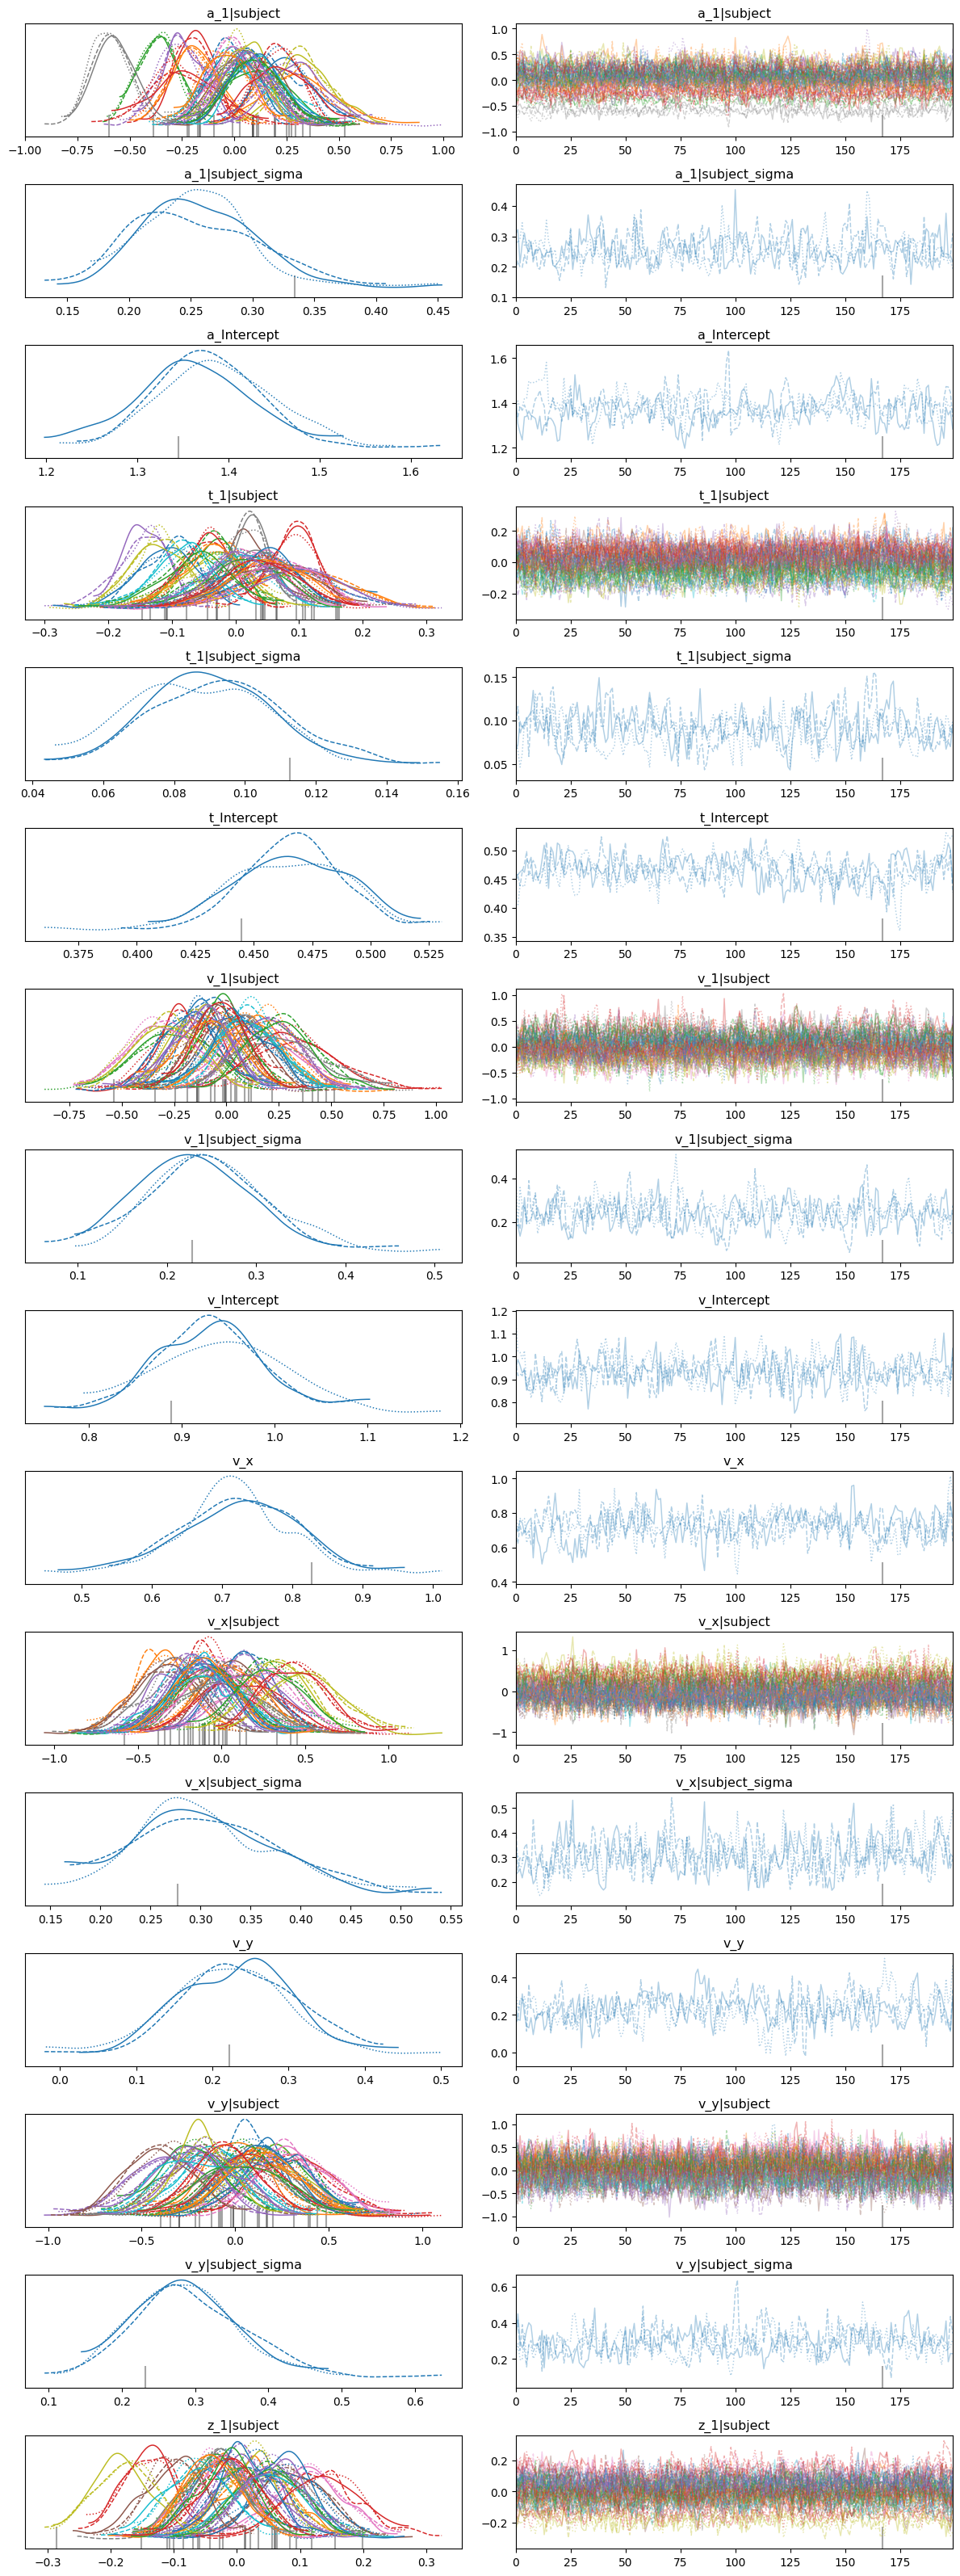

In [ ]:
az.rcParams["plot.max_subplots"] = 32
az.plot_trace(samples_model_reg_v_ddm_hier1A)
plt.tight_layout()
plt.show()

# Save & load the model (debug)

In [ ]:
# Save
samples_model_reg_v_ddm_hier1A.to_netcdf('modelTraces')

# Load
modelObject = az.InferenceData.from_netcdf('modelTraces')

# Re-attach
samples_model_reg_v_ddm_hier1A._inference_obj = modelObject

In [ ]:
samples_model_reg_v_ddm_hier1A

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data